In [478]:
# imports
import pandas as pd
import sqlite3
from urllib.request import urlopen
from urllib.error import URLError
from bs4 import BeautifulSoup
from datetime import datetime
from collections import OrderedDict
import numpy as np
import itertools as it
from geopy.distance import great_circle # for calculating distances
import matplotlib.pyplot as plt
%matplotlib inline

## Read, explore and organize supplied airport data

In [2]:
# read supplied csv files of airport info
ica = pd.read_csv('data/ICAO_airports.csv') # info for all (I think) airports
ta = pd.read_csv('data/top_airports.csv') # info for top 50 airports

In [3]:
# explore ica data
ica.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,6524,00AK,small_airport,Lowell Field,59.949200,-151.695999,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
2,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
3,6526,00AR,heliport,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,00AR,NaN,00AR,NaN,NaN,NaN
4,6527,00AZ,small_airport,Cordes Airport,34.305599,-112.165001,3810.0,NaN,US,US-AZ,Cordes,no,00AZ,NaN,00AZ,NaN,NaN,NaN


In [4]:
# explore ta data
ta.head()

,City,FAA,IATA,ICAO,Airport,Role,Enplanements
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962


In [617]:
# we can join the data from the two files by merging the dataframes on the common airport codes
ica['ICAO'] = ica['ident']
combined_info = ta.merge(ica, on='ICAO')
combined_info

,City,FAA,IATA,ICAO,Airport,Role,Enplanements,id,ident,type,...,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,Atlanta,ATL,ATL,KATL,Hartsfield-Jackson Atlanta International Airport,P-L,43130585,3384,KATL,large_airport,...,US,US-GA,Atlanta,yes,KATL,ATL,ATL,http://www.atlanta-airport.com/,http://en.wikipedia.org/wiki/Hartsfield-Jackso...,NaN
1,Chicago,ORD,ORD,KORD,Chicago O'Hare International Airport,P-L,32171831,3754,KORD,large_airport,...,US,US-IL,Chicago,yes,KORD,ORD,ORD,http://www.flychicago.com/Ohare/OhareHomepage....,http://en.wikipedia.org/wiki/O'Hare_Internatio...,"CHI, Orchard Place"
2,Los Angeles,LAX,LAX,KLAX,Los Angeles International Airport,P-L,30528737,3632,KLAX,large_airport,...,US,US-CA,Los Angeles,yes,KLAX,LAX,LAX,http://www.iflylax.com/,http://en.wikipedia.org/wiki/Los_Angeles_Inter...,NaN
3,Dallas-Fort Worth,DFW,DFW,KDFW,Dallas/Fort Worth International Airport,P-L,27100656,3488,KDFW,large_airport,...,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,DFW,http://www.dfwairport.com/,http://en.wikipedia.org/wiki/Dallas-Fort_Worth...,QDF
4,Denver,DEN,DEN,KDEN,Denver International Airport,P-L,25241962,3486,KDEN,large_airport,...,US,US-CO,Denver,yes,KDEN,DEN,DEN,http://www.flydenver.com/,http://en.wikipedia.org/wiki/Denver_Internatio...,NaN
5,New York,JFK,JFK,KJFK,John F. Kennedy International Airport,P-L,22934047,3622,KJFK,large_airport,...,US,US-NY,New York,yes,KJFK,JFK,JFK,http://www.panynj.gov/CommutingTravel/airports...,http://en.wikipedia.org/wiki/John_F._Kennedy_I...,"Manhattan, New York City, NYC, Idlewild"
6,San Francisco,SFO,SFO,KSFO,San Francisco International Airport,P-L,20038679,3878,KSFO,large_airport,...,US,US-CA,San Francisco,yes,KSFO,SFO,SFO,http://www.flysfo.com/,http://en.wikipedia.org/wiki/San_Francisco_Int...,"QSF, QBA"
7,Houston,IAH,IAH,KIAH,George Bush Intercontinental Airport,P-L,19528631,3604,KIAH,large_airport,...,US,US-TX,Houston,yes,KIAH,IAH,IAH,http://www.fly2houston.com/iah,http://en.wikipedia.org/wiki/George_Bush_Inter...,QHO
8,Las Vegas,LAS,LAS,KLAS,McCarran International Airport,P-L,18996738,3631,KLAS,large_airport,...,US,US-NV,Las Vegas,yes,KLAS,LAS,LAS,http://www.mccarran.com/,http://en.wikipedia.org/wiki/McCarran_Internat...,NaN
9,Phoenix,PHX,PHX,KPHX,Phoenix Sky Harbor International Airport,P-L,18907171,3772,KPHX,large_airport,...,US,US-AZ,Phoenix,yes,KPHX,PHX,PHX,http://phoenix.gov/skyharborairport/,http://en.wikipedia.org/wiki/Phoenix_Sky_Harbo...,NaN


## Build out weather scraping functionality

In [609]:
def wund_ex_query(airport, start_date, day, mnth, yr, syr, smnth, keep_cols, results):
    '''
    helper function to fn: wund_ap_hist_scrape - not intended to be used as a standalone
    '''
    
    # assemble url
    url = 'https://www.wunderground.com/history/airport/{}/{}/CustomHistory.html?dayend={}&monthend={}&yearend={}'.format(
            airport, start_date, day, mnth, yr)
    
    # go to url and read html response
    response = urlopen(url)
    html = response.read()
    response.close()
    
    # parse response into beautiful soup format
    soup = BeautifulSoup(html, "html.parser")
    
    # the table we need is the second one - extract it
    table = soup.findAll('table')[1]
    
    # iterate through all rows in table
    for row_cnt, row in enumerate(table.findAll('tr')):
        
        # all header rows contain the word 'sum' and will be ignored
        if 'sum' not in row.text:
            
            # make list to hold results for row
            row_res = []
            
            # iterate through all columns in current row
            for idx, col in enumerate(row.findAll('td')):
                
                # check if index is one of the columns requested in keep_cols
                if idx in keep_cols.values():
                    
                    # extract column value as string and append to row_res
                    row_res.append(''.join([s.rstrip() for s in col.findAll(text=True)]))
            
            # deal with date formatting
            if (row_res == []) and (row_cnt != 0):
                if smnth < 12:
                    smnth += 1
                elif smnth == 12:
                    syr += 1
                    smnth = 1
            elif row_res != []:
                # deal with missing date rows by using the previous day's values
                if (results != []) and (int(row_res[0]) != 1) and (int(row_res[0]) > int(results[-1][0].split('/')[2]) + 1):
                    for i in range(int(row_res[0]) - int(results[-1][0].split('/')[2]) - 1):
                        tmp = results[-1]
                        old_date = tmp[0].split('/')
                        new_date = '{}/{}/{}'.format(old_date[0], old_date[1], 1 + int(old_date[2]))
                        results.append([new_date] + tmp[1:])
                    row_res[0] = '{}/{}/{}'.format(syr, smnth, row_res[0])
                    results.append(row_res)
                else:
                    row_res[0] = '{}/{}/{}'.format(syr, smnth, row_res[0])
                    results.append(row_res)

In [610]:
def wund_ap_hist_scrape(airport = 'KSFO', start_date = '2008/1/1', end_date = 'today',
                       keep_cols = {'day_of_month': 0, 'high_temp': 1, 'avg_temp': 2, 'low_temp': 3,
                                    'avg_humidity': 8, 'precipitation': 19}):
    '''
    scrapes weather underground historical data for a given airport over a specified date range
        and returns dataframe with results
        
    Parameters
    -----------
    airport : airport code (four letter string)
    start_date : starting date required for history (fmt: YYYY/MM/DD)
    end_date : ending date required for history (fmt: YYYY/MM/DD or 'today')
    keep_cols : dictionary with keys of strings to be used as column names in output df and values that
                are the indices of the columns in weather underground table that correspond to them
                
    Returns
    --------
    pandas dataframe of results over specified date range with columns labeled from keep_cols dictionary
    '''
    
    # we will need the keep_cols dict to be ordered by value
    keep_cols = OrderedDict(sorted(keep_cols.items(), key = lambda t:t[1]))
    
    # determine end date based on input and put into required format
    if end_date == 'today':
        now = datetime.now()
        yr = now.year
        mnth = now.month
        day = now.day
        end_date = '{}/{}/{}'.format(yr, mnth, day)
    else:
        tmp = end_date.split('/')
        yr = tmp[0]
        mnth = tmp[1]
        day = tmp[2]
        
    # extract start yr and month
    tmp = start_date.split('/')
    syr = int(tmp[0])
    smnth = int(tmp[1])
    
    # make list to hold results
    results = []
    
    # calculate difference in years between start and end to determine how many queries to make
    yr_diff = (datetime.strptime(end_date, '%Y/%m/%d') - datetime.strptime(start_date, '%Y/%m/%d')).total_seconds() / (60 * 60 * 24 * 365.25)
    
    # break request into the appropraite number of queries
    if yr_diff < 0:
        raise ValueError('start date must be earlier than end date!')
    elif yr_diff <= 1:
        wund_ex_query(airport, start_date, day, mnth, yr, syr, smnth, keep_cols, results)
    elif yr_diff > 1:
        wund_ex_query(airport, start_date, 31, 12, syr, syr, smnth, keep_cols, results)
        for yy in range(syr + 1, syr + int(yr_diff)):
            wund_ex_query(airport, '{}/1/1'.format(yy), 31, 12, yy, yy, 1, keep_cols, results)
        wund_ex_query(airport, '{}/1/1'.format(yr), day, mnth, yr, yr, 1, keep_cols, results)
            
    # collect results into dataframe, cast columns to appropriate type, and return
    df = pd.DataFrame(results, columns=keep_cols.keys())
    for col in ['high_temp', 'avg_temp', 'low_temp', 'avg_humidity', 'precipitation']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.fillna(0)

## Create and write data to sqlite3 database

In [612]:
# create database and structure

connection = sqlite3.connect('data/airports.db')
cursor = connection.cursor()

# command to create airport_info table
sql_airport_info_cmd = """CREATE TABLE airport_info (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    name TEXT,
    nearest_city TEXT,
    latitude_deg FLOAT,
    longitude_deg FLOAT,
    elev FLOAT,
    enplanements INT)"""

# commad to create airport_weather table
sql_airport_weather_cmd = """CREATE TABLE airport_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ICAO TEXT,
    date DATE,
    high_temp FLOAT,
    avg_temp FLOAT,
    low_temp FLOAT,
    avg_humidity FLOAT,
    precipitation FLOAT)"""

cursor.execute(sql_airport_info_cmd)
cursor.execute(sql_airport_weather_cmd)
connection.commit()

In [613]:
# NB: this will take a WHILE to run
# had to resort to a while loop with error handling b/c weather underground kept interfering with the scrape

# populate tables
for i, row in combined_info.iterrows():
    
    print('Iteration: {}'.format(i))
    
    # get params from combined info dataframe
    info_params = (row['ICAO'], row['Airport'], row['City'], row['latitude_deg'], row['longitude_deg'],
                  row['elevation_ft'], row['Enplanements'])
    
    # write into airport_info table
    cursor.execute('INSERT INTO airport_info' + \
                  '(ICAO, name, nearest_city, latitude_deg, longitude_deg, elev, enplanements) ' +\
                  'VALUES (?, ?, ?, ?, ?, ?, ?)', info_params)
    
    # query for dataframe of weather info
    while True:
        try:
            weather_df = wund_ap_hist_scrape(airport = row['ICAO'])
            break
        except URLError:
            print('Interrupted: trying again...')
            pass
    
    # add all rows from weather_df to airport_weather table
    for wi, wrow in weather_df.iterrows():
        
        # get weather params from row
        w_params = (row['ICAO'], datetime.strptime(wrow['day_of_month'], '%Y/%m/%d'), wrow['high_temp'], 
                    wrow['avg_temp'], wrow['low_temp'], wrow['avg_humidity'], wrow['precipitation'])
        
        # write into table
        cursor.execute('INSERT INTO airport_weather' + \
                      '(ICAO, date, high_temp, avg_temp, low_temp, avg_humidity, precipitation) ' + \
                      'VALUES (?, ?, ?, ?, ?, ? , ?)', w_params)

connection.commit()

Iteration: 0
Iteration: 1
Interrupted: trying again...
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Interrupted: trying again...
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Interrupted: trying again...
Interrupted: trying again...
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Interrupted: trying again...
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49


## analysis

In [614]:
# set up connetion to db so that lists of values can be returned instead of lists of tuples
connection.row_factory = lambda cursor, row: row[0]
c = connection.cursor()

In [615]:
# pull airport code from database
#code_cmd = 'SELECT ICAO FROM airport_info where ICAO != "KIAH" and ICAO != "KLGA" and ICAO != "KMSY" and ICAO != "KIND"'
code_cmd = 'SELECT ICAO FROM airport_info'
codes = c.execute(code_cmd).fetchall()
len(codes)

50

In [616]:
# iterate through all permutations of pairs of airport codes, calculate correlation coefficients, and store results
res_dict = {'pair': [], 'hT_1': [], 'hT_3': [], 'hT_7': [], 'p_1': [], 'p_3': [], 'p_7': [], 'dist': [], 'long_diff': []}
for pair in it.permutations(codes, 2):
    
    # pull needed weather info for each airport
    p0T = c.execute('SELECT high_temp FROM airport_weather WHERE ICAO = "{}"'.format(pair[0])).fetchall()
    p0pr = c.execute('SELECT precipitation FROM airport_weather WHERE ICAO = "{}"'.format(pair[0])).fetchall()
    p1T = c.execute('SELECT high_temp FROM airport_weather WHERE ICAO = "{}"'.format(pair[1])).fetchall()
    p1pr = c.execute('SELECT precipitation FROM airport_weather WHERE ICAO = "{}"'.format(pair[1])).fetchall()
    
    # correlation strengths are computed as the average of the off-diagonal elements computed by
    #    corrcoef between data for one airport and data for the other airport advanced by 1,3, or 7 days
    res_dict['hT_1'].append(np.mean(np.corrcoef(p0T[:-1], p1T[1:])[0,1]))
    res_dict['hT_3'].append(np.mean(np.corrcoef(p0T[:-3], p1T[3:])[0,1]))
    res_dict['hT_7'].append(np.mean(np.corrcoef(p0T[:-7], p1T[7:])[0,1]))
    res_dict['p_1'].append(np.mean(np.corrcoef(p0pr[:-1], p1pr[1:])[0,1]))
    res_dict['p_3'].append(np.mean(np.corrcoef(p0pr[:-3], p1pr[3:])[0,1]))
    res_dict['p_7'].append(np.mean(np.corrcoef(p0pr[:-7], p1pr[7:])[0,1]))
    
    # pull location coordinates and calculate distances
    lat0 = c.execute('SELECT latitude_deg FROM airport_info WHERE ICAO = "{}"'.format(pair[0])).fetchall()[0]
    long0 = c.execute('SELECT longitude_deg FROM airport_info WHERE ICAO = "{}"'.format(pair[0])).fetchall()[0]
    lat1 = c.execute('SELECT latitude_deg FROM airport_info WHERE ICAO = "{}"'.format(pair[1])).fetchall()[0]
    long1 = c.execute('SELECT longitude_deg FROM airport_info WHERE ICAO = "{}"'.format(pair[1])).fetchall()[0]
    
    # calculate and store distance between airports
    res_dict['dist'].append(great_circle((lat0,long0),(lat1,long1)).miles)
    
    # calculate and store longitude difference
    res_dict['long_diff'].append(long1-long0)
    
    # store pair
    res_dict['pair'].append(pair)
    
correlations = pd.DataFrame(res_dict)

In [618]:
correlations

,dist,hT_1,hT_3,hT_7,long_diff,p_1,p_3,p_7,pair
0,606.832917,0.799416,0.769490,0.764703,-3.476700,-0.027974,-0.007976,0.005998,"(KATL, KORD)"
1,1942.814738,0.303210,0.335047,0.363819,-33.979897,0.020083,-0.005717,-0.005239,"(KATL, KLAX)"
2,730.025887,0.770433,0.742180,0.745655,-12.609901,-0.049343,-0.015655,0.009449,"(KATL, KDFW)"
3,1197.482139,0.666448,0.690823,0.702475,-20.244896,-0.020910,-0.011114,-0.023092,"(KATL, KDEN)"
4,759.587605,0.857789,0.802000,0.794981,10.649200,0.146895,-0.000657,-0.007300,"(KATL, KJFK)"
5,2134.836180,0.519590,0.535281,0.553068,-37.946899,0.018305,-0.012045,-0.011111,"(KATL, KSFO)"
6,688.401392,0.800233,0.748102,0.743206,-10.913300,-0.037861,-0.003025,0.022304,"(KATL, KIAH)"
7,1743.330326,0.753744,0.772774,0.774837,-30.723900,-0.011950,-0.011805,0.001162,"(KATL, KLAS)"
8,1584.371935,0.737733,0.762766,0.765161,-27.583900,-0.020219,-0.009060,-0.015915,"(KATL, KPHX)"
9,226.595296,0.906927,0.794965,0.758109,3.485001,0.198273,-0.008369,0.023039,"(KATL, KCLT)"


## Plot Results

In [629]:
def plot_res_one_each(df, x_vals = {'dist': 'Distance (mi)', 'long_diff': 'Longitude Difference (Deg.)'},
             y_vals = {'hT_1': 'High Temperature (1 Day)', 'hT_3': 'High Temperature (3 Day)', 'hT_7': 'High Temperature (7 Day)'}):
    '''
    make plots of results
    '''
    
    # generate figure and axes
    fig, ax = plt.subplots(len(x_vals), len(y_vals), figsize = (4* len(y_vals), 4* len(x_vals)))
    
    # iterate through all parameters
    for xi, x in enumerate(x_vals.keys()):
        for yi, y in enumerate(y_vals.keys()):
            
            # label plots
            ax[xi,yi].set_xlabel(x_vals[x])
            ax[xi,yi].set_ylabel('Correlation Strength')
            ax[xi,yi].set_title(y_vals[y])
            
            # select needed subset of data for plot
            tmp_df = df.sort_values(y, ascending = False).iloc[:10]
            
            # plot data and add labels
            ax[xi,yi].plot(tmp_df[x], tmp_df[y], 'k*')
            for i, row in tmp_df.iterrows():
                xlim = ax[xi,yi].get_xlim()
                ax[xi,yi].text(row[x] + 0.03*(xlim[1] - xlim[0]), row[y],
                               '{}\n{}'.format(row['pair'][0], row['pair'][1]), size='smaller', va='center')
            
    plt.tight_layout()

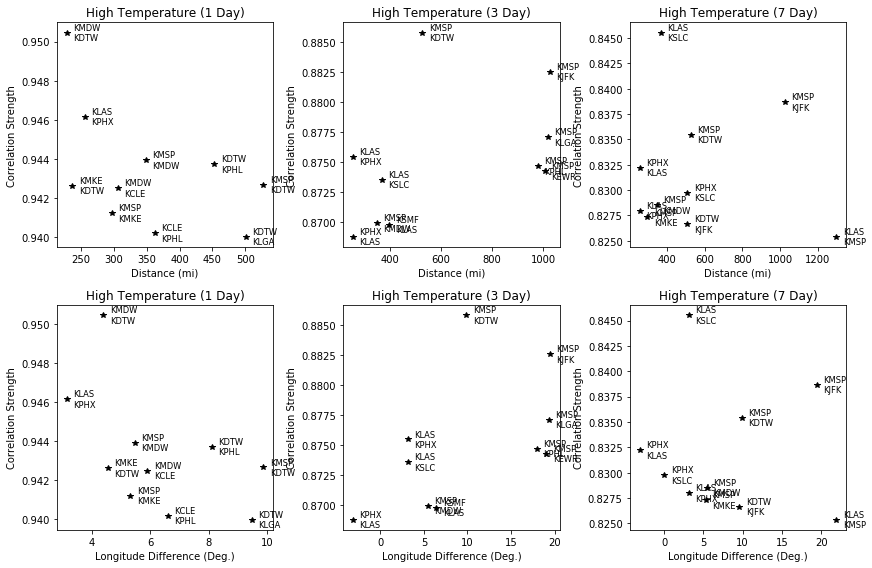

In [630]:
plot_res_one_each(correlations)

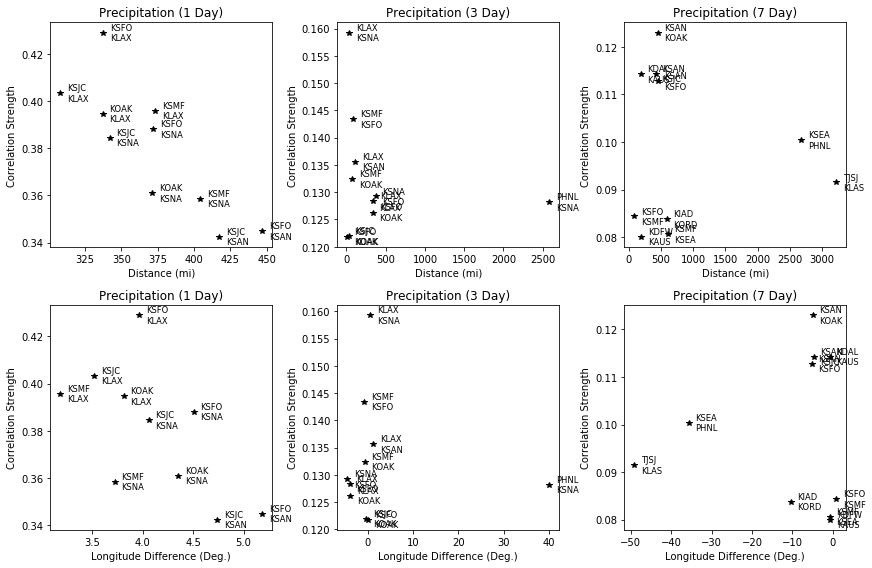

In [631]:
plot_res_one_each(correlations, y_vals = {'p_1': 'Precipitation (1 Day)', 'p_3': 'Precipitation (3 Day)', 'p_7': 'Precipitation (7 Day)'})

In [644]:
# I think the data may be easier to interpret by combining each set of three horizontal panes into one
def plot_res_together(df, x_vals = {'dist': 'Distance (mi)', 'long_diff': 'Longitude Difference (Deg.)'},
             y_vals = {'hT_1': 'High Temperature (1 Day)', 'hT_3': 'High Temperature (3 Day)', 'hT_7': 'High Temperature (7 Day)'},
             colors = ['k','r','b']):
    '''
    make plots of results
    '''
    
    # generate figure and axes
    fig, ax = plt.subplots(1, len(x_vals), figsize = (12, 3 * len(x_vals)))
    
    # iterate through all parameters
    for xi, x in enumerate(x_vals.keys()):
        for yi, y in enumerate(y_vals.keys()):
            
            # label plots
            ax[xi].set_xlabel(x_vals[x])
            ax[xi].set_ylabel('Correlation Strength')
            #ax[xi].set_title(y_vals[y])
            
            # select needed subset of data for plot
            tmp_df = df.sort_values(y, ascending = False).iloc[:10]
            
            # plot data and add labels
            ax[xi].plot(tmp_df[x], tmp_df[y], '*', label = y_vals[y])
            ax[xi].legend(loc = 'best')
            #for i, row in tmp_df.iterrows():
            #    xlim = ax[xi].get_xlim()
            #    ax[xi].text(row[x] + 0.01*(xlim[1] - xlim[0]), row[y],
            #                   '{}\n{}'.format(row['pair'][0], row['pair'][1]), size='smaller', va='center')
            
    plt.tight_layout()

Temperature Results


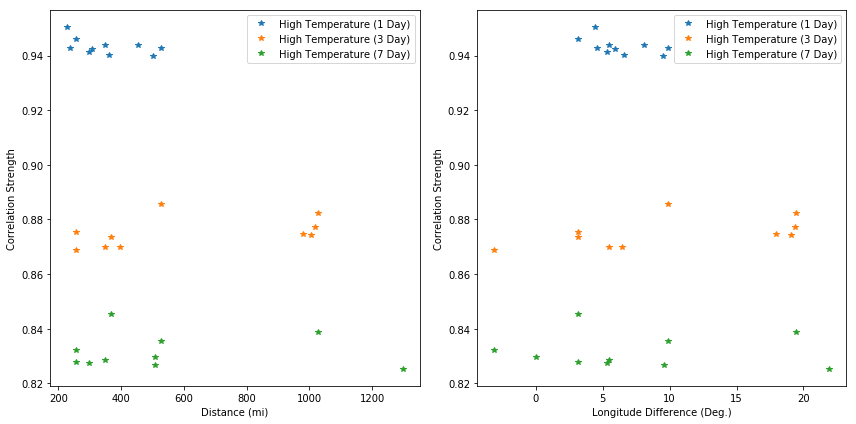

In [648]:
plot_res_together(correlations)
print('Temperature Results')

By visualizing our temperature results in the plots above, there are several observations to make:
* Maximum temperature correlations show a hierarchy - in terms of the top ten pairs, cities were always more correlated at one day than at three, and always more correlated at three days than seven. This is exactly what I had expected.
* The correlations between cities after one day were much more localized in terms the parameter they are plotted against (ie distance or longitude difference) than after three days or seven days. In terms of distances between cities, the best correlated pairs after one day were roughly 400 miles apart on average with relatively small variance. In terms of lingitude difference they were between 5 and 10 degrees, again with relatively low variance.
* The correlations appear to have relatively similar variances in terms of correlation strength, though they also show a hierarchy towards being more dispersed for later times.

Precipitation Results


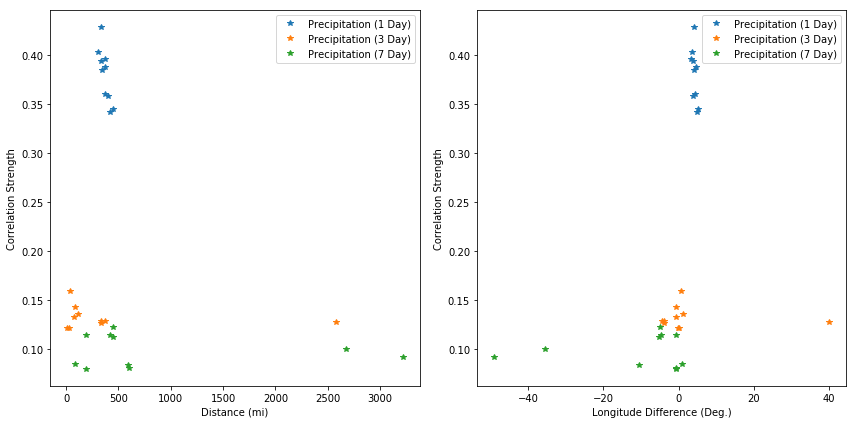

In [649]:
plot_res_together(correlations, y_vals = {'p_1': 'Precipitation (1 Day)', 'p_3': 'Precipitation (3 Day)', 'p_7': 'Precipitation (7 Day)'})
print('Precipitation Results')

When looking at the precipitatation results, we can again see qualitatively similar features.
* There is again a hierarchy in correlation strengths, although the correlations at one day are markedly higher than those at three and seven days which are much closer together. It is worth noting that the correlations were much weaker in an absolute sense for precipitation than for high temperature. In the precipitation case, the strongest correlation might have a strength of roughly 0.45 where as with high temperature the highest is closer to 0.95.
* Again correlations between cities are much more localized in terms of distance or longitude distance after one day than after three or seven days. In the case of precipitation after three or seven days, there appear to be outliers that boost the variances considerably. For there to be a correlation at distances so large as 3000 mi seems hard to believe (though with a strength of 0.1, the presence of these points is not very telling).
* In terms of the variances for correlation strength, one day has perhaps the largest variance for precipitation, where as for high temperature this was the opposite.